In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [2]:
#Stock screening for Most actively traded stocks in NASDAQ. 
url_volume = ("https://www.marketwatch.com/tools/screener/market?exchange=nasdaq&subreport=mostactive")
page = requests.get(url_volume)
soup_volume = BeautifulSoup(page.text, 'lxml')
volume = soup_volume.findAll('div', class_= 'cell__content fixed--cell')
most_active_tickers = []
for div_tag in soup_volume.findAll('div', class_= 'cell__content fixed--cell'):
     most_active_tickers.append(div_tag.text) 
most_active_tickers.pop(0)  

'Symbol'

In [3]:
# Defining Risk and Performance measurement KPIs
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return 100*CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [4]:
# BACKTESTING - Download historical data (5min) for stocks after screening 
#Example #tickers = ["AMD","SOFI","AFRM","AAPL","GT","Z","NVDA","ORPH","FB","DKNG","PTON","AAL","ASTR","MU","MSFT","GRAB","TSLA"]
tickers = most_active_tickers 

ohlc_intraday = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(30)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_intraday[ticker] = yf.download(ticker,start,end,interval='5m')
    ohlc_intraday[ticker].dropna(inplace=True,how="all")
    #ohlc_intraday[ticker].drop(ohlc_intraday[ticker].tail(1).index,inplace=True)

tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
################################Backtesting####################################

# creating the datastructure-calculating ATR,rolling max price, rolling min price, rolling maximum volume for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
#signal_info = {}
#signal_df = pd.DataFrame(columns = ['Ticker-name','Buy-Signal', 'Sell-Signal', 'Trailing-SL-Signal'])
#All_signal_df = pd.DataFrame()
NaN=np.nan
for ticker in tickers:
    #print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker]["Signal"] = "None"
    ohlc_dict[ticker]["Buy_Price"] = 0.0
    ohlc_dict[ticker]["Sell_Price"] = 0.0
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = [0]
    #signal_info[ticker] = [0]


In [6]:
# identifying signals and calculating intraday return (stop loss factored in)
#ticker = 'AAL'

All_signal_data={}
#signal=[NaN,NaN,NaN,NaN]
for ticker in tickers:
    #print("calculating returns for ",ticker)
    Buy_Signal = 0
    Sell_Signal = 0
    Stop_Loss_Signal = 0
    
    #data = []
    
    for i in range(1,len(ohlc_dict[ticker])):
        
        if tickers_signal[ticker] == "":
            #this is for 1st row where retun is not calculated
            tickers_ret[ticker].append(0)
           
            #this is for Buy after signal becomes blank
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and                ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                #print("this is for Buy after signal becomes blank for ",ticker)
                Buy_Signal = Buy_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Long-Buy"
                ohlc_dict[ticker]["Buy_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
                
            #this is for sell after signal becomes blank
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and                ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                #print("this is for Sell after signal becomes blank for ",ticker)
                Sell_Signal = Sell_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Short-Sell"
                ohlc_dict[ticker]["Sell_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
        
        elif tickers_signal[ticker] == "Buy":
            #this is for Stop-loss after Buy
            if ohlc_dict[ticker]["Low"][i]<ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Close"][i-1])-1)
                Stop_Loss_Signal = Stop_Loss_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Exiting-After-Long-Buy-At-Trailing-SL"
                ohlc_dict[ticker]["Sell_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
            #this is for sell after Buy   
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and                ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                Sell_Signal = Sell_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Short-Sell-Criteria-Matches-After-Long-Buy"
                ohlc_dict[ticker]["Sell_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
            #this is for hold after Buy 
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
                ohlc_dict[ticker]["Signal"][i]="Holding-After-Long-Buy"
                
                
        elif tickers_signal[ticker] == "Sell":
            #this is for Stop-loss after Sell
            if ohlc_dict[ticker]["High"][i]>ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/(ohlc_dict[ticker]["Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
                Stop_Loss_Signal = Stop_Loss_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Exiting-After-Short-Sell-At-Trailing-SL"
                ohlc_dict[ticker]["Buy_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
            #this is for Buy after Sell
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and                ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                Buy_Signal = Buy_Signal + 1
                ohlc_dict[ticker]["Signal"][i]="Long-Buy-Criteria-Matches-After-Short-Sell"
                ohlc_dict[ticker]["Buy_Price"][i]=ohlc_dict[ticker]["Adj Close"][i]
            #this is for hold after Sell
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
                ohlc_dict[ticker]["Signal"][i]="Holding-After-Short-Sell"
                
        signal = [ticker,Buy_Signal,Sell_Signal,Stop_Loss_Signal]               
        
    All_signal_data[ticker]=pd.DataFrame(signal)

    All_signal_data[ticker]=All_signal_data[ticker].T
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

C:\Users\toram\anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\toram\anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\toram\anaconda3\envs\quant\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\toram\anaconda3\envs\quant\lib\site-packages\ipykernel_lau

<function matplotlib.pyplot.show(close=None, block=None)>

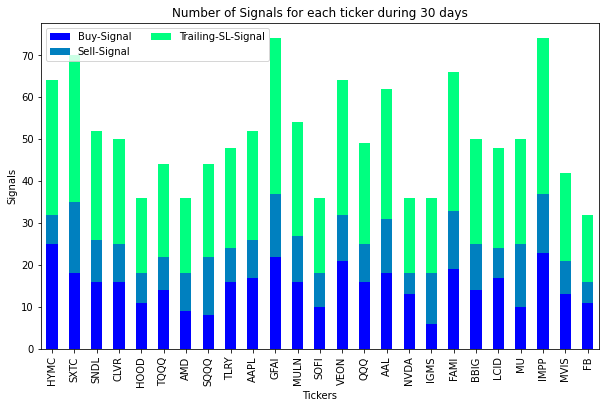

In [7]:
final=pd.concat(list(All_signal_data.values()),ignore_index=True)
names=["Ticker-name","Buy-Signal","Sell-Signal","Trailing-SL-Signal"]
final.columns=names

#print(final)

#stackd_bar=final.T

#Generating the stacked bar chart

final.plot(kind='bar',stacked=True,colormap='winter',figsize=(10,6))

plt.legend(loc='upper left',ncol=2)
plt.xlabel("Tickers")
plt.xticks(ticks=np.arange(0,25,1),labels=final['Ticker-name'])
plt.ylabel("Signals")
plt.title('Number of Signals for each ticker during 30 days')
plt.show

In [8]:
# calculating overall strategy's KPIs
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [9]:
# showing the KPI values
print("The CAGR for portfolio is :",CAGR(strategy_df))
print("The Sharpe ratio for portfolio is :",sharpe(strategy_df,0.015))
print("The maximum drawdown of portfolio is :",100*max_dd(strategy_df)) 

The CAGR for portfolio is : 96.00290843721208
The Sharpe ratio for portfolio is : 733.1370853931513
The maximum drawdown of portfolio is : 3.339249513559265


Text(0.5, 1.0, 'Cumulative Return')

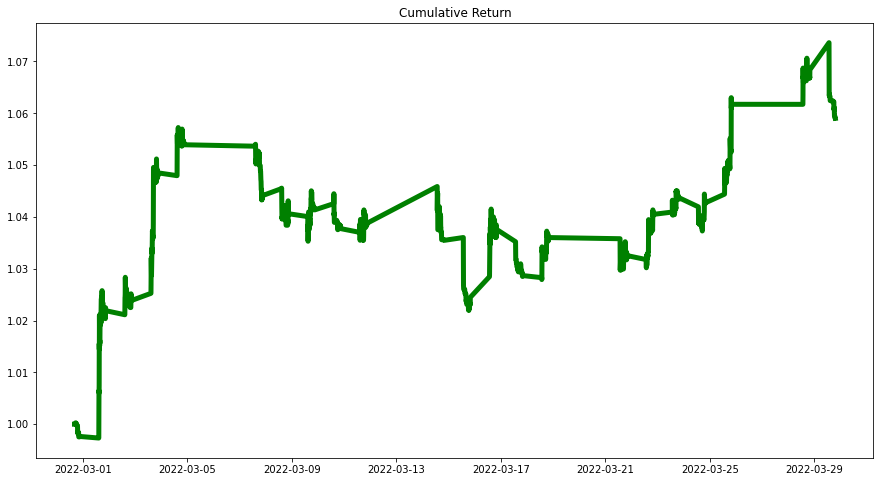

In [10]:
# vizualization of strategy return
fig, ax = plt.subplots(figsize=(15,8))
plt.plot((1+strategy_df["ret"]).cumprod(),color='green', linestyle='-',linewidth=5)
plt.title('Cumulative Return')

In [11]:
#calculating KPIs for Index buy and hold strategy over the same period
NASDAQ100 = yf.download("QQQM",start,end,interval='5m')
NASDAQ100.drop(NASDAQ100.tail(1).index,inplace=True)
NASDAQ100["ret"] = NASDAQ100["Adj Close"].pct_change().fillna(0)


# In[11]:


print("The CAGR for QQQM(ETF of NASDAQ100) is:",CAGR(NASDAQ100))


# In[26]:


print("The sharpe ratio for QQQM(ETF of NASDAQ100) is:",sharpe(NASDAQ100,0.025))
print("The maximum drawdown(in %) for QQQM(ETF of NASDAQ100) is:",100*max_dd(NASDAQ100))

[*********************100%***********************]  1 of 1 completed
The CAGR for QQQM(ETF of NASDAQ100) is: 144.69423306388066
The sharpe ratio for QQQM(ETF of NASDAQ100) is: 513.023922360387
The maximum drawdown(in %) for QQQM(ETF of NASDAQ100) is: 9.013784314619128


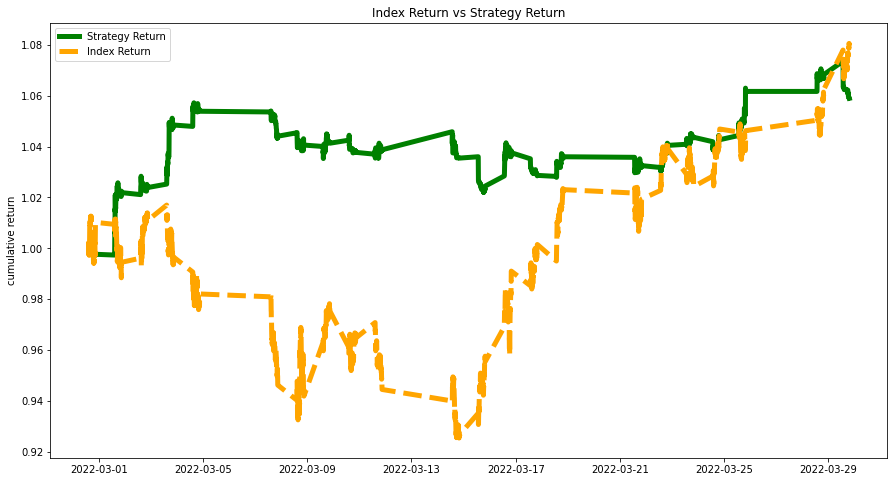

In [12]:
#visualization
fig, ax = plt.subplots(figsize=(15,8))
plt.plot((1+strategy_df["ret"]).cumprod(),color='green', linestyle='-',linewidth=5)
plt.plot((1+NASDAQ100["ret"]).cumprod(),color='orange', linestyle='dashed',linewidth=5)
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
#plt.xlabel("Intraday Return")
ax.legend(["Strategy Return","Index Return"])


In [13]:
#Radar Plot (log)
import math
KPIs=['CAGR(log)',"SharpeRatio(log)",'MaxDrawdown(log)']
Strategy=[math.log(CAGR(strategy_df)),math.log(sharpe(strategy_df,0.015)),math.log(100*max_dd(strategy_df))]
Nasdaq=[math.log(CAGR(NASDAQ100)),math.log(sharpe(NASDAQ100,0.025)),math.log(100*max_dd(NASDAQ100))]

import plotly.graph_objects as go
KPIs=['CAGR(log)',"SharpeRatio(log)",'MaxDrawdown(log)']
fig=go.Figure()
fig.add_trace(go.Scatterpolar(r=Strategy,theta=KPIs,fill='toself',name='Strategy KPI'))
fig.add_trace(go.Scatterpolar(r=Nasdaq,theta=KPIs,fill='toself',name='Nasdaq KPI'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0,10])),showlegend=True)
fig.show()

In [14]:
#Radar Plot (scaling)
import math
KPIs=['CAGR',"SharpeRatio",'MaxDrawdown']
Strategy=[CAGR(strategy_df),1/10*sharpe(strategy_df,0.015),1000*max_dd(strategy_df)]
Nasdaq=[CAGR(NASDAQ100),1/10*sharpe(NASDAQ100,0.025),1000*max_dd(NASDAQ100)]

import plotly.graph_objects as go
KPIs=['CAGR',"SharpeRatio",'MaxDrawdown']
fig=go.Figure()
fig.add_trace(go.Scatterpolar(r=Strategy,theta=KPIs,fill='toself',name='Strategy KPI'))
fig.add_trace(go.Scatterpolar(r=Nasdaq,theta=KPIs,fill='toself',name='Nasdaq100 KPI'))
fig.update_layout(polar=dict(radialaxis=dict(visible=True,range=[0,300])),showlegend=True)
fig.show()

In [15]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
stock_name = {}
for ticker in tickers:
    #print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])
    stock_name[ticker] = ticker

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown,stock_name],index=["Return","Sharpe Ratio","Max Drawdown","Stock Name"])      
KPI_df.T


Return  Sharpe Ratio Max Drawdown Stock Name
HYMC    134.972119    128.132041      0.17504       HYMC
SXTC    -41.236952    -61.336926     0.179605       SXTC
SNDL      69.23651    168.486893     0.106738       SNDL
CLVR    100.989837     95.685775     0.157629       CLVR
HOOD    160.538274    432.738047     0.082697       HOOD
TQQQ     14.175987     67.207265     0.049781       TQQQ
AMD      -3.449565    -23.677032     0.032113        AMD
SQQQ     39.113539    173.406972     0.043079       SQQQ
TLRY     -7.538158    -20.592521     0.104294       TLRY
AAPL     -9.952432   -117.210264     0.028251       AAPL
GFAI    -92.000556    -98.371734       0.2284       GFAI
MULN  54871.336655  43825.637261     0.216676       MULN
SOFI     11.171237     41.109377     0.037065       SOFI
VEON   7203.067433   5701.447056     0.279354       VEON
QQQ       18.23048    208.060526     0.011759        QQQ
AAL      76.718249     348.29933     0.047773        AAL
NVDA    -34.574219   -293.157415      0.03582       NVDA
IGMS      52.08874    315.021743     0.026376       IGMS
FAMI    -80.806492   -300.696867     0.148236       FAMI
BBIG    -64.336454   -196.852904     0.124361       BBIG
LCID    315.983061   1390.717605     0.028939       LCID
MU       55.394396    320.067533     0.045612         MU
IMPP    743.631231     633.95107     0.290737       IMPP
MVIS    -44.322011   -201.791505     0.080025       MVIS
FB       36.816454    342.149017     0.027413         FB

In [16]:
KPI_df_T=KPI_df.T


# In[16]:


KPI_df_T.head(25)


# In[17]:


import yfinance as yf
ma_df_bubble=pd.DataFrame(np.nan,index=['marketCap','Symbols','averageVolume'],
               columns=tickers)

for ticker in tickers:
    try:
        ma_df_bubble[ticker].iloc[0]=yf.Ticker(ticker).info['marketCap']
        ma_df_bubble[ticker].iloc[1]=ticker
        ma_df_bubble[ticker].iloc[2]=yf.Ticker(ticker).info['averageVolume']
    except:
        print("Some value is missing")
    


# In[18]:


#Joing the tables
KPI_df_T=KPI_df_T.join(ma_df_bubble.T)


# In[19]:


KPI_df_T


# In[20]:


KPI_df_T['averageVolume'] = KPI_df_T['averageVolume'].astype(int)


# In[21]:


KPI_df_T.head(2)

C:\Users\toram\anaconda3\envs\quant\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Return Sharpe Ratio Max Drawdown Stock Name    marketCap Symbols  \
HYMC  134.972119   128.132041      0.17504       HYMC  290636768.0    HYMC   
SXTC  -41.236952   -61.336926     0.179605       SXTC    8458320.0    SXTC   

      averageVolume  
HYMC       35092585  
SXTC        6601649

In [17]:
fig = px.scatter(KPI_df_T, x="Max Drawdown", y="Sharpe Ratio",
	         size="averageVolume", color="Stock Name",
                 hover_name=KPI_df_T["Stock Name"], log_x=True, log_y=True, size_max=60,color_continuous_scale='rainbow')
fig.show()

In [18]:
fig = px.scatter(KPI_df_T, x="Return", y="Sharpe Ratio",
	         size="averageVolume", color="Stock Name",
                 hover_name=KPI_df_T["Stock Name"], log_x=True, log_y=True, size_max=60,color_continuous_scale='rainbow')
fig.show()

In [19]:
fig = px.scatter(KPI_df_T, x="Sharpe Ratio", y="Max Drawdown",
	         size="averageVolume", color="Stock Name",
                 hover_name=KPI_df_T["Stock Name"], log_x=True, log_y=True, size_max=60,color_continuous_scale='rainbow')
fig.show()

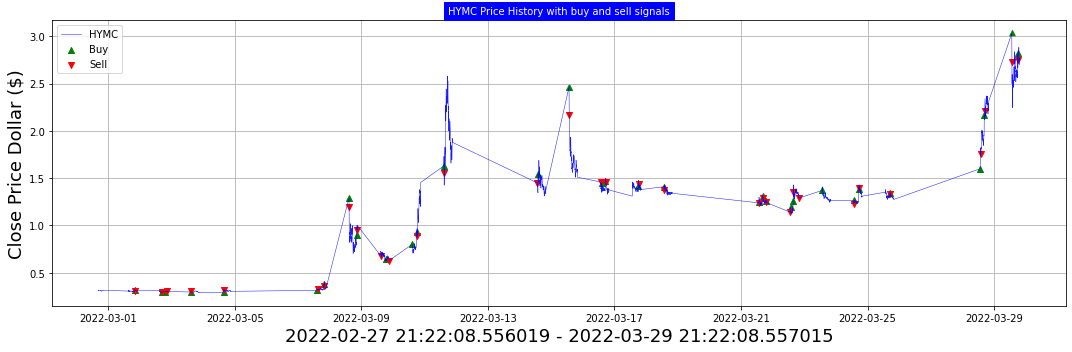

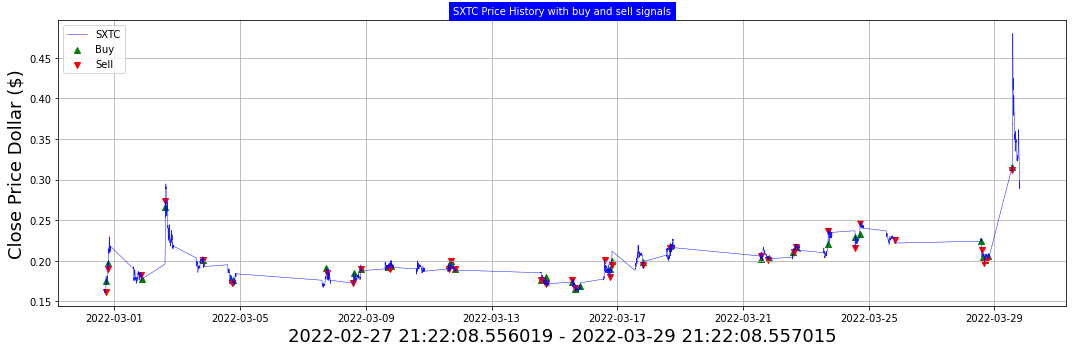

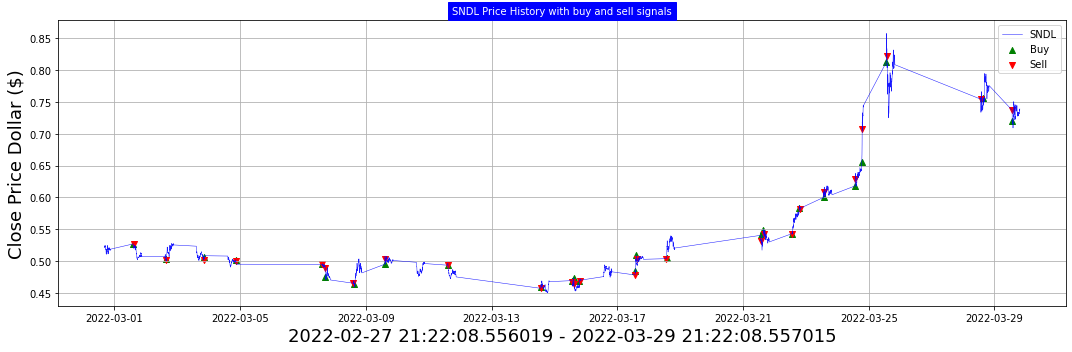

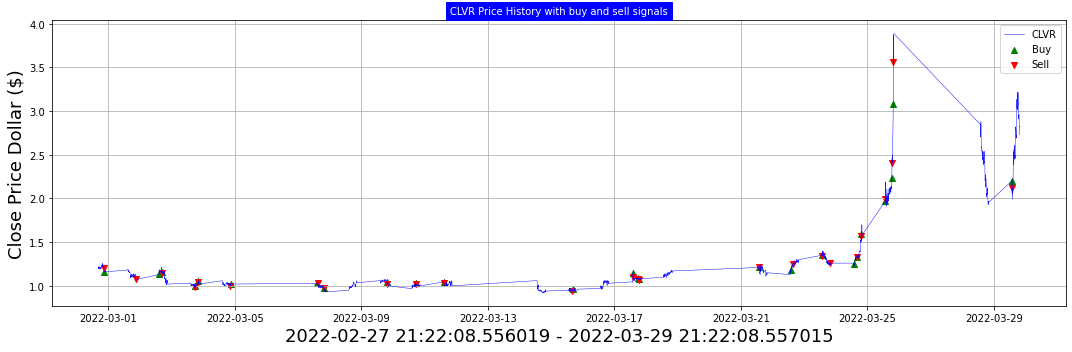

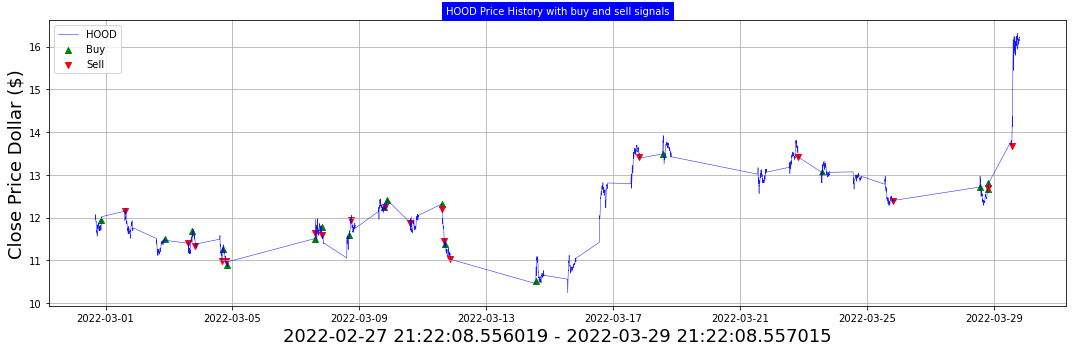

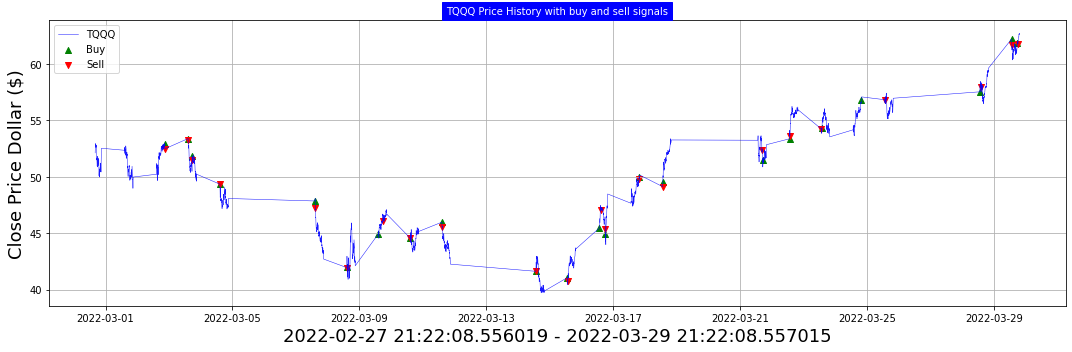

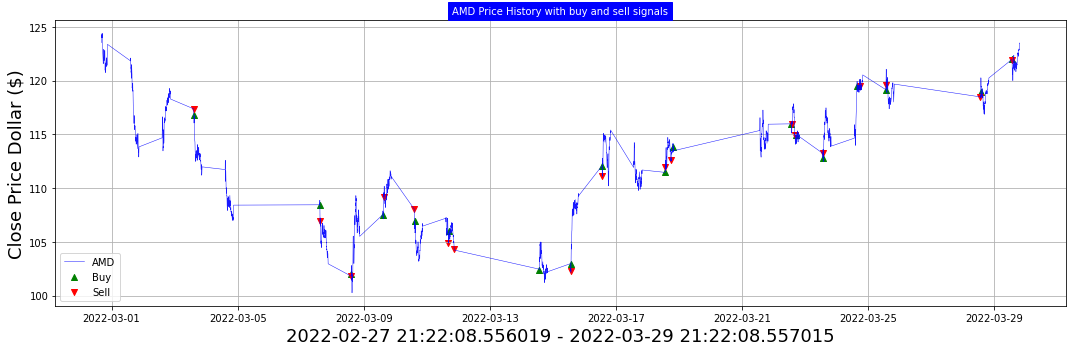

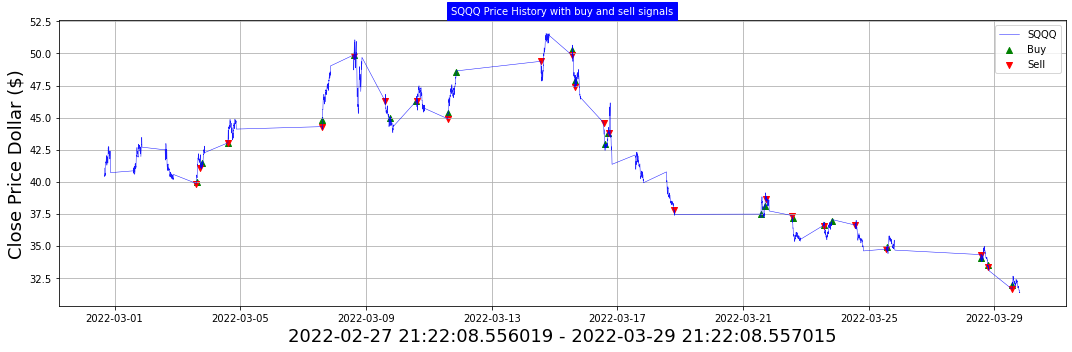

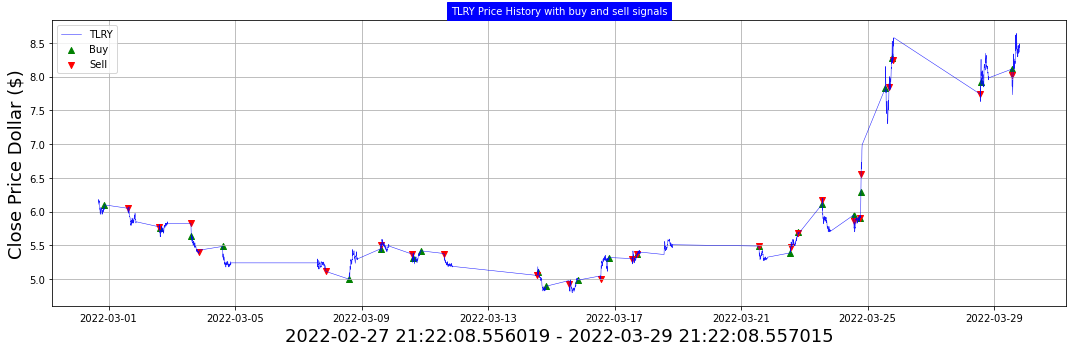

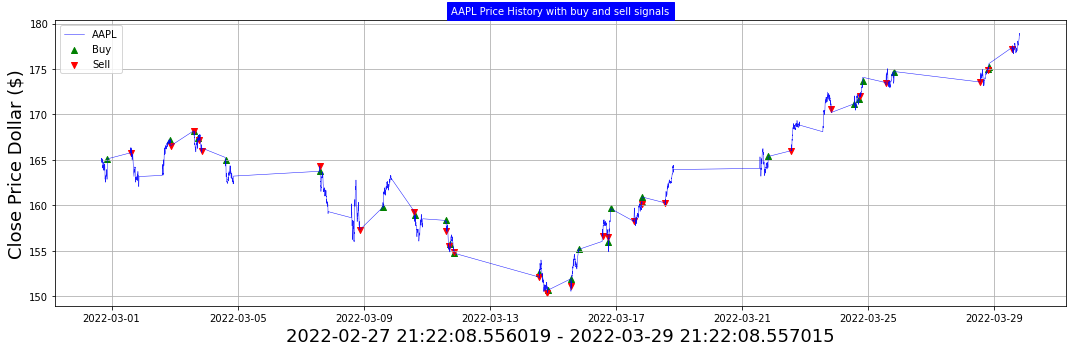

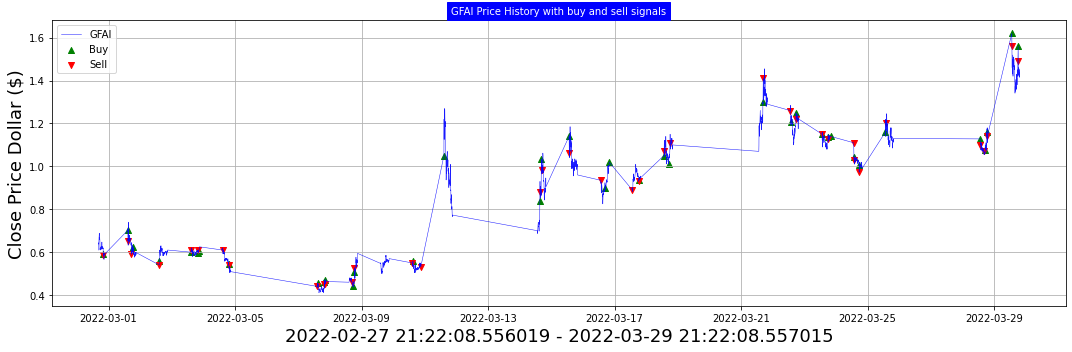

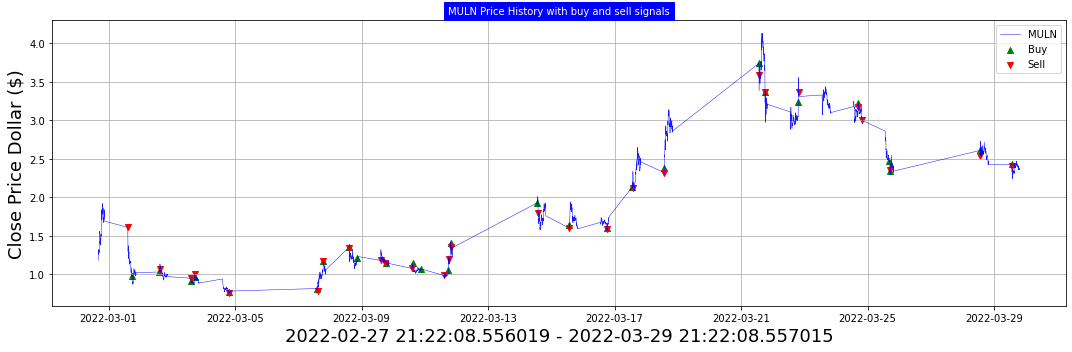

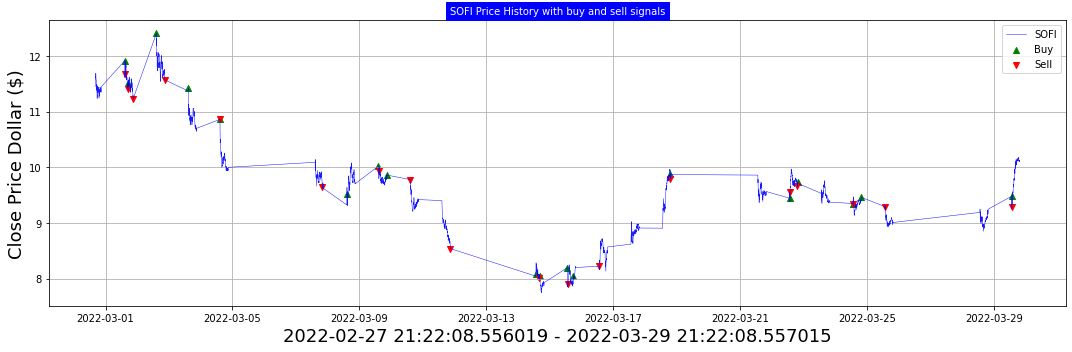

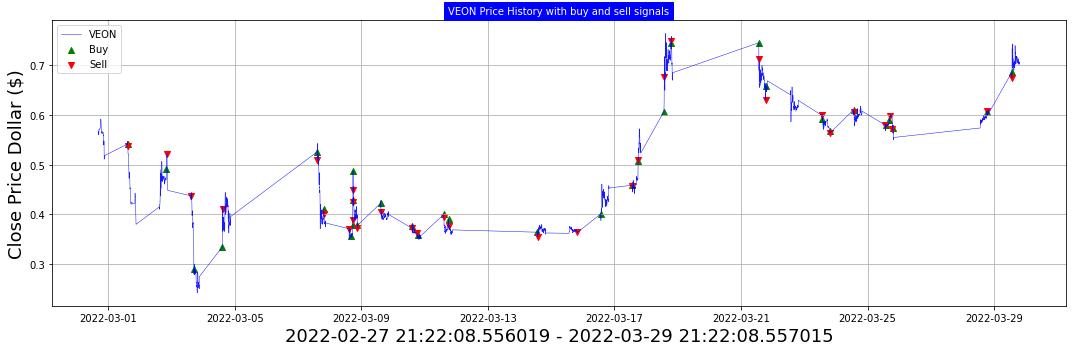

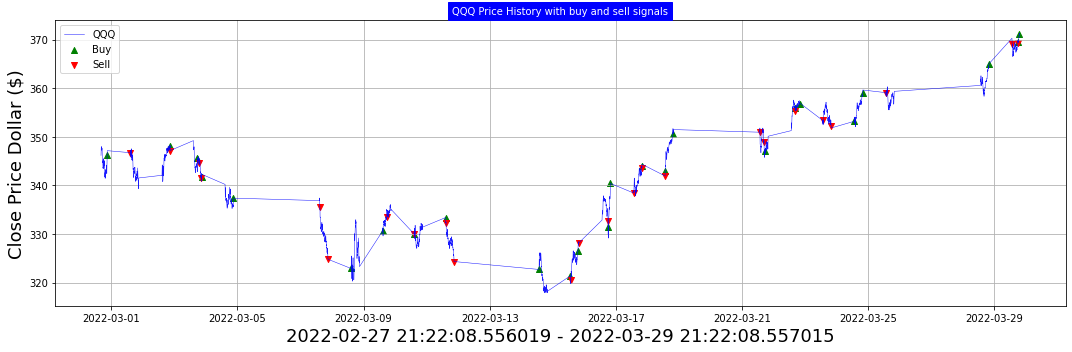

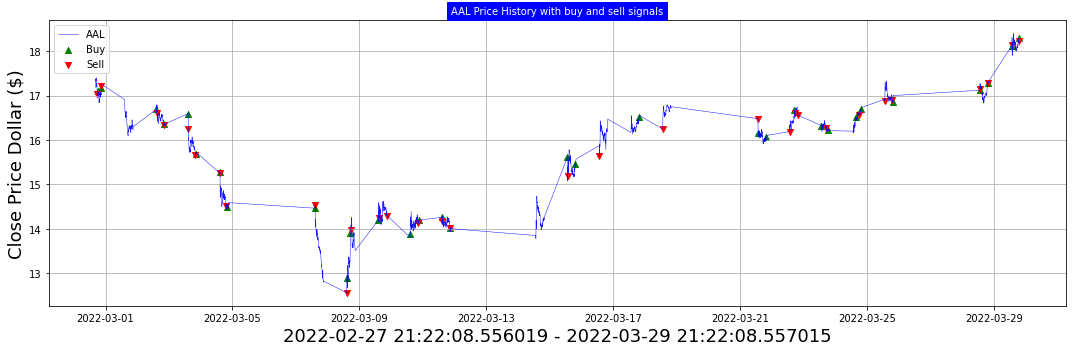

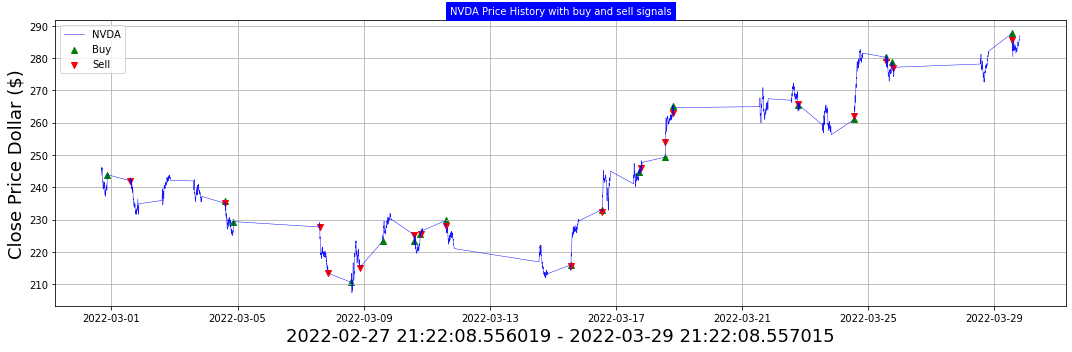

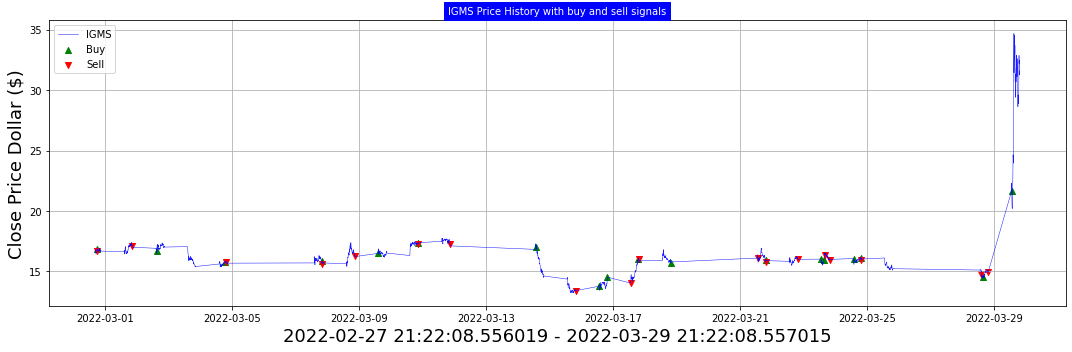

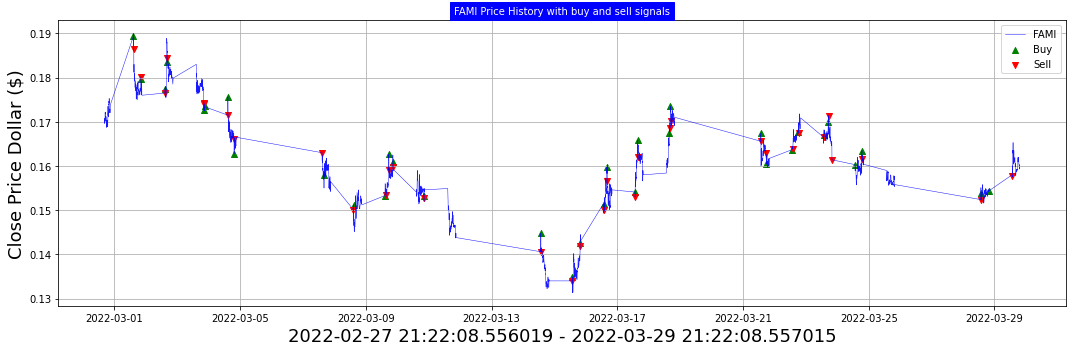

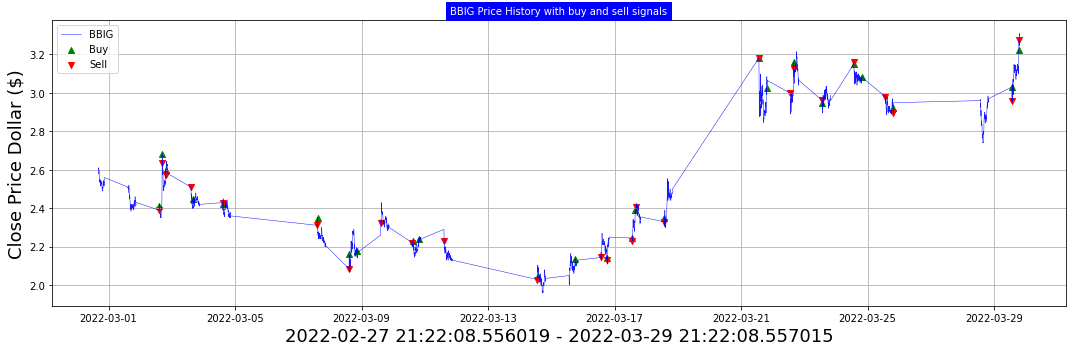

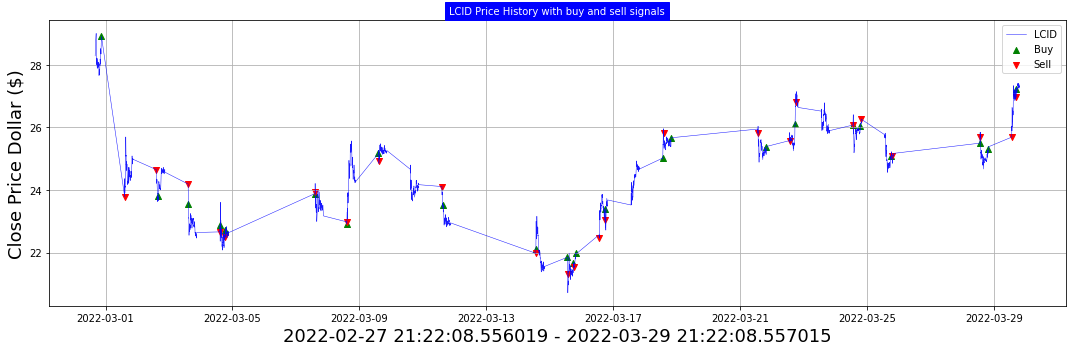

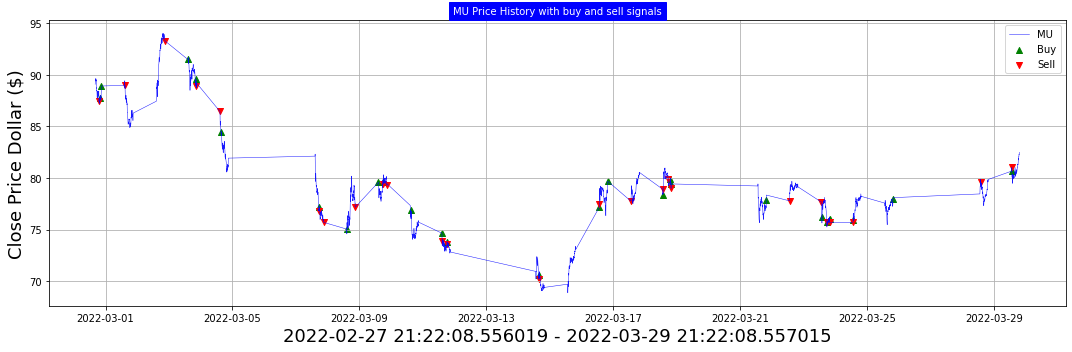

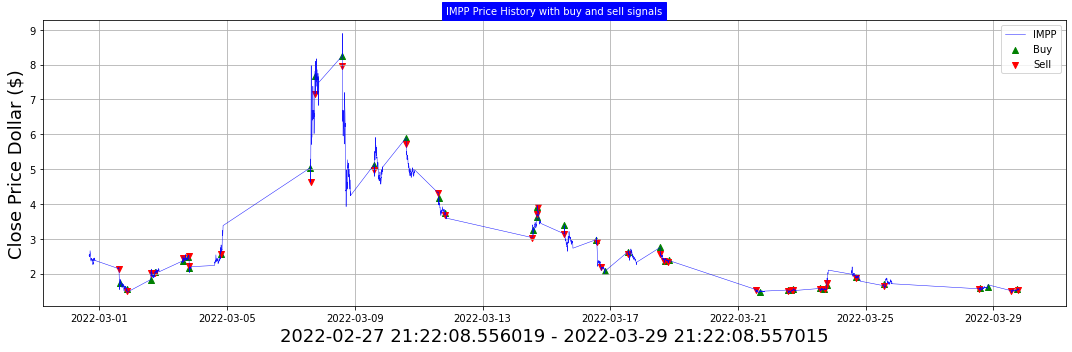

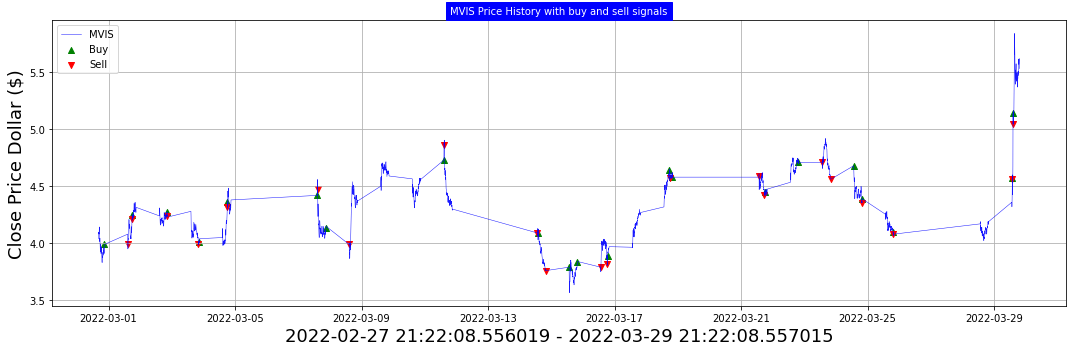

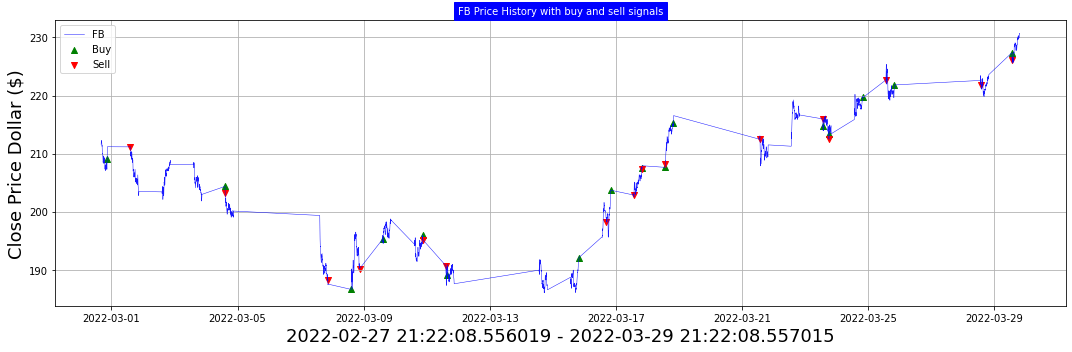

In [20]:
for ticker in most_active_tickers :
#ticker = most_active_tickers[22]

    ohlc_show = copy.deepcopy(ohlc_dict)
    ohlc_show[ticker]
    ohlc_show[ticker].replace(0, np.nan, inplace=True)   
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(ohlc_show[ticker]['Adj Close'] , label = ticker ,linewidth=0.5, color='blue', alpha = 0.9)
    #ax.plot(ohlc_show[ticker]['roll_max_cp'], label = 'Average-Max-CP', alpha = 0.85)
    #ax.plot(ohlc_show[ticker]['roll_min_cp'], label = 'Average-Min-CP' , alpha = 0.85)
    ax.scatter(ohlc_show[ticker].index , ohlc_show[ticker]['Buy_Price'] , label = 'Buy' , marker = '^', color = 'green',alpha =1 )
    ax.scatter(ohlc_show[ticker].index , ohlc_show[ticker]['Sell_Price'] , label = 'Sell' , marker = 'v', color = 'red',alpha =1 )
    ax.set_title(ticker + " Price History with buy and sell signals",fontsize=10, backgroundcolor='blue', color='white')
    ax.set_xlabel(f'{start} - {end}' ,fontsize=18)
    ax.set_ylabel('Close Price Dollar ($)' , fontsize=18)
    legend = ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

In [21]:
print(len(most_active_tickers))

25
